In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import stan 

import arviz as az 

import nest_asyncio
nest_asyncio.apply()

In [25]:
# Read in the data

dataset = pd.read_csv("../data/full_data.csv", delimiter=";")

In [26]:
dataset.head(5)

,Timestamp,Lap_Number,Position.x.,Position.y.,Position.z.,Orientation.y.,Gaze_Location.x.,Gaze_Location.y.,Gaze_Location.z.,Subject,Gaze.x.,Gaze.y.,d_ang,ang_accel,Gate_N,Gate_Ang,Ang_Pos
0,1688764397665,0,-255.4,347.4990,-181.9740,0.000000e+00,-270.755071,351.018900,-138.681686,1,1157.191,434.2069,0.000000e+00,1.333622e-07,1,-22.572101,202.572101
1,1688764397682,0,-255.4,347.5181,-181.8494,-3.000000e-08,-270.743971,351.035293,-138.685157,1,1157.282,434.3420,-1.764706e-07,2.209487e-06,1,-22.572101,202.572101
2,1688764397699,0,-255.4,347.5356,-181.7235,0.000000e+00,-270.748529,351.077679,-138.680800,1,1157.288,434.6814,-1.764706e-07,3.604383e-09,1,-22.572101,202.572101
3,1688764397715,0,-255.4,347.5516,-181.5985,0.000000e+00,-270.753086,351.120064,-138.676443,1,1157.295,435.0208,-9.803922e-09,3.604383e-09,1,-22.572101,202.572101
4,1688764397732,0,-255.4,347.5663,-181.4766,0.000000e+00,-270.460614,351.141679,-138.868614,1,1159.131,435.3366,-9.803922e-09,-1.099337e-06,1,-22.572101,202.572101


In [29]:
## Get rid of data with extreme values
dataset = dataset[(dataset['Gaze.x.'] != 0) & (dataset['Gaze.x.'] != 2560) & (dataset['Gaze.y.'] != 0) & (dataset['Gaze.y.'] != 1080)]

<Axes: xlabel='Gaze.x.', ylabel='Gaze.y.'>

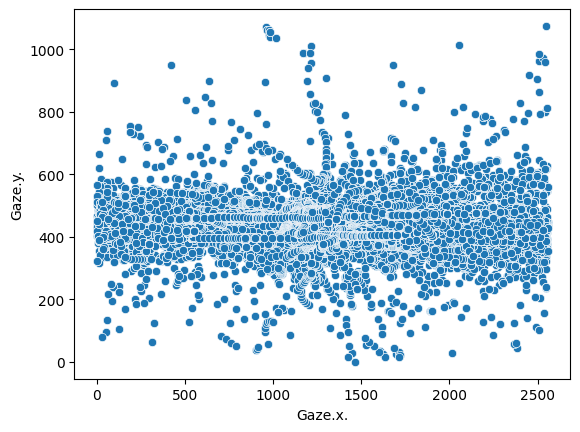

In [30]:
sns.scatterplot(x=dataset['Gaze.x.'], y=dataset['Gaze.y.'])